In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 3.23G/3.24G [00:36<00:00, 35.2MB/s]
100% 3.24G/3.24G [00:36<00:00, 95.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/a-large-scale-fish-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import random
import matplotlib.image as mpimg
from sklearn.manifold import TSNE

In [ ]:
DIR = '/content/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(DIR) if '.' not in i]

In [ ]:
label = []
path = []
for dirname, _, filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            file_path = os.path.join(dirname, filename)
            class_name = dirname.split('/')[-1]
            if 'GT' not in class_name:
                path.append(file_path)
                label.append(class_name)

data_df = pd.DataFrame({'filepath': path, 'label': label})

In [ ]:
data_df.head()

filepath            label
0  /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat
1  /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat
2  /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat
3  /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat
4  /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat

In [ ]:
data_df.describe()

filepath            label
count                                                9000             9000
unique                                               9000                9
top     /content/Fish_Dataset/Fish_Dataset/Black Sea S...  Black Sea Sprat
freq                                                    1             1000

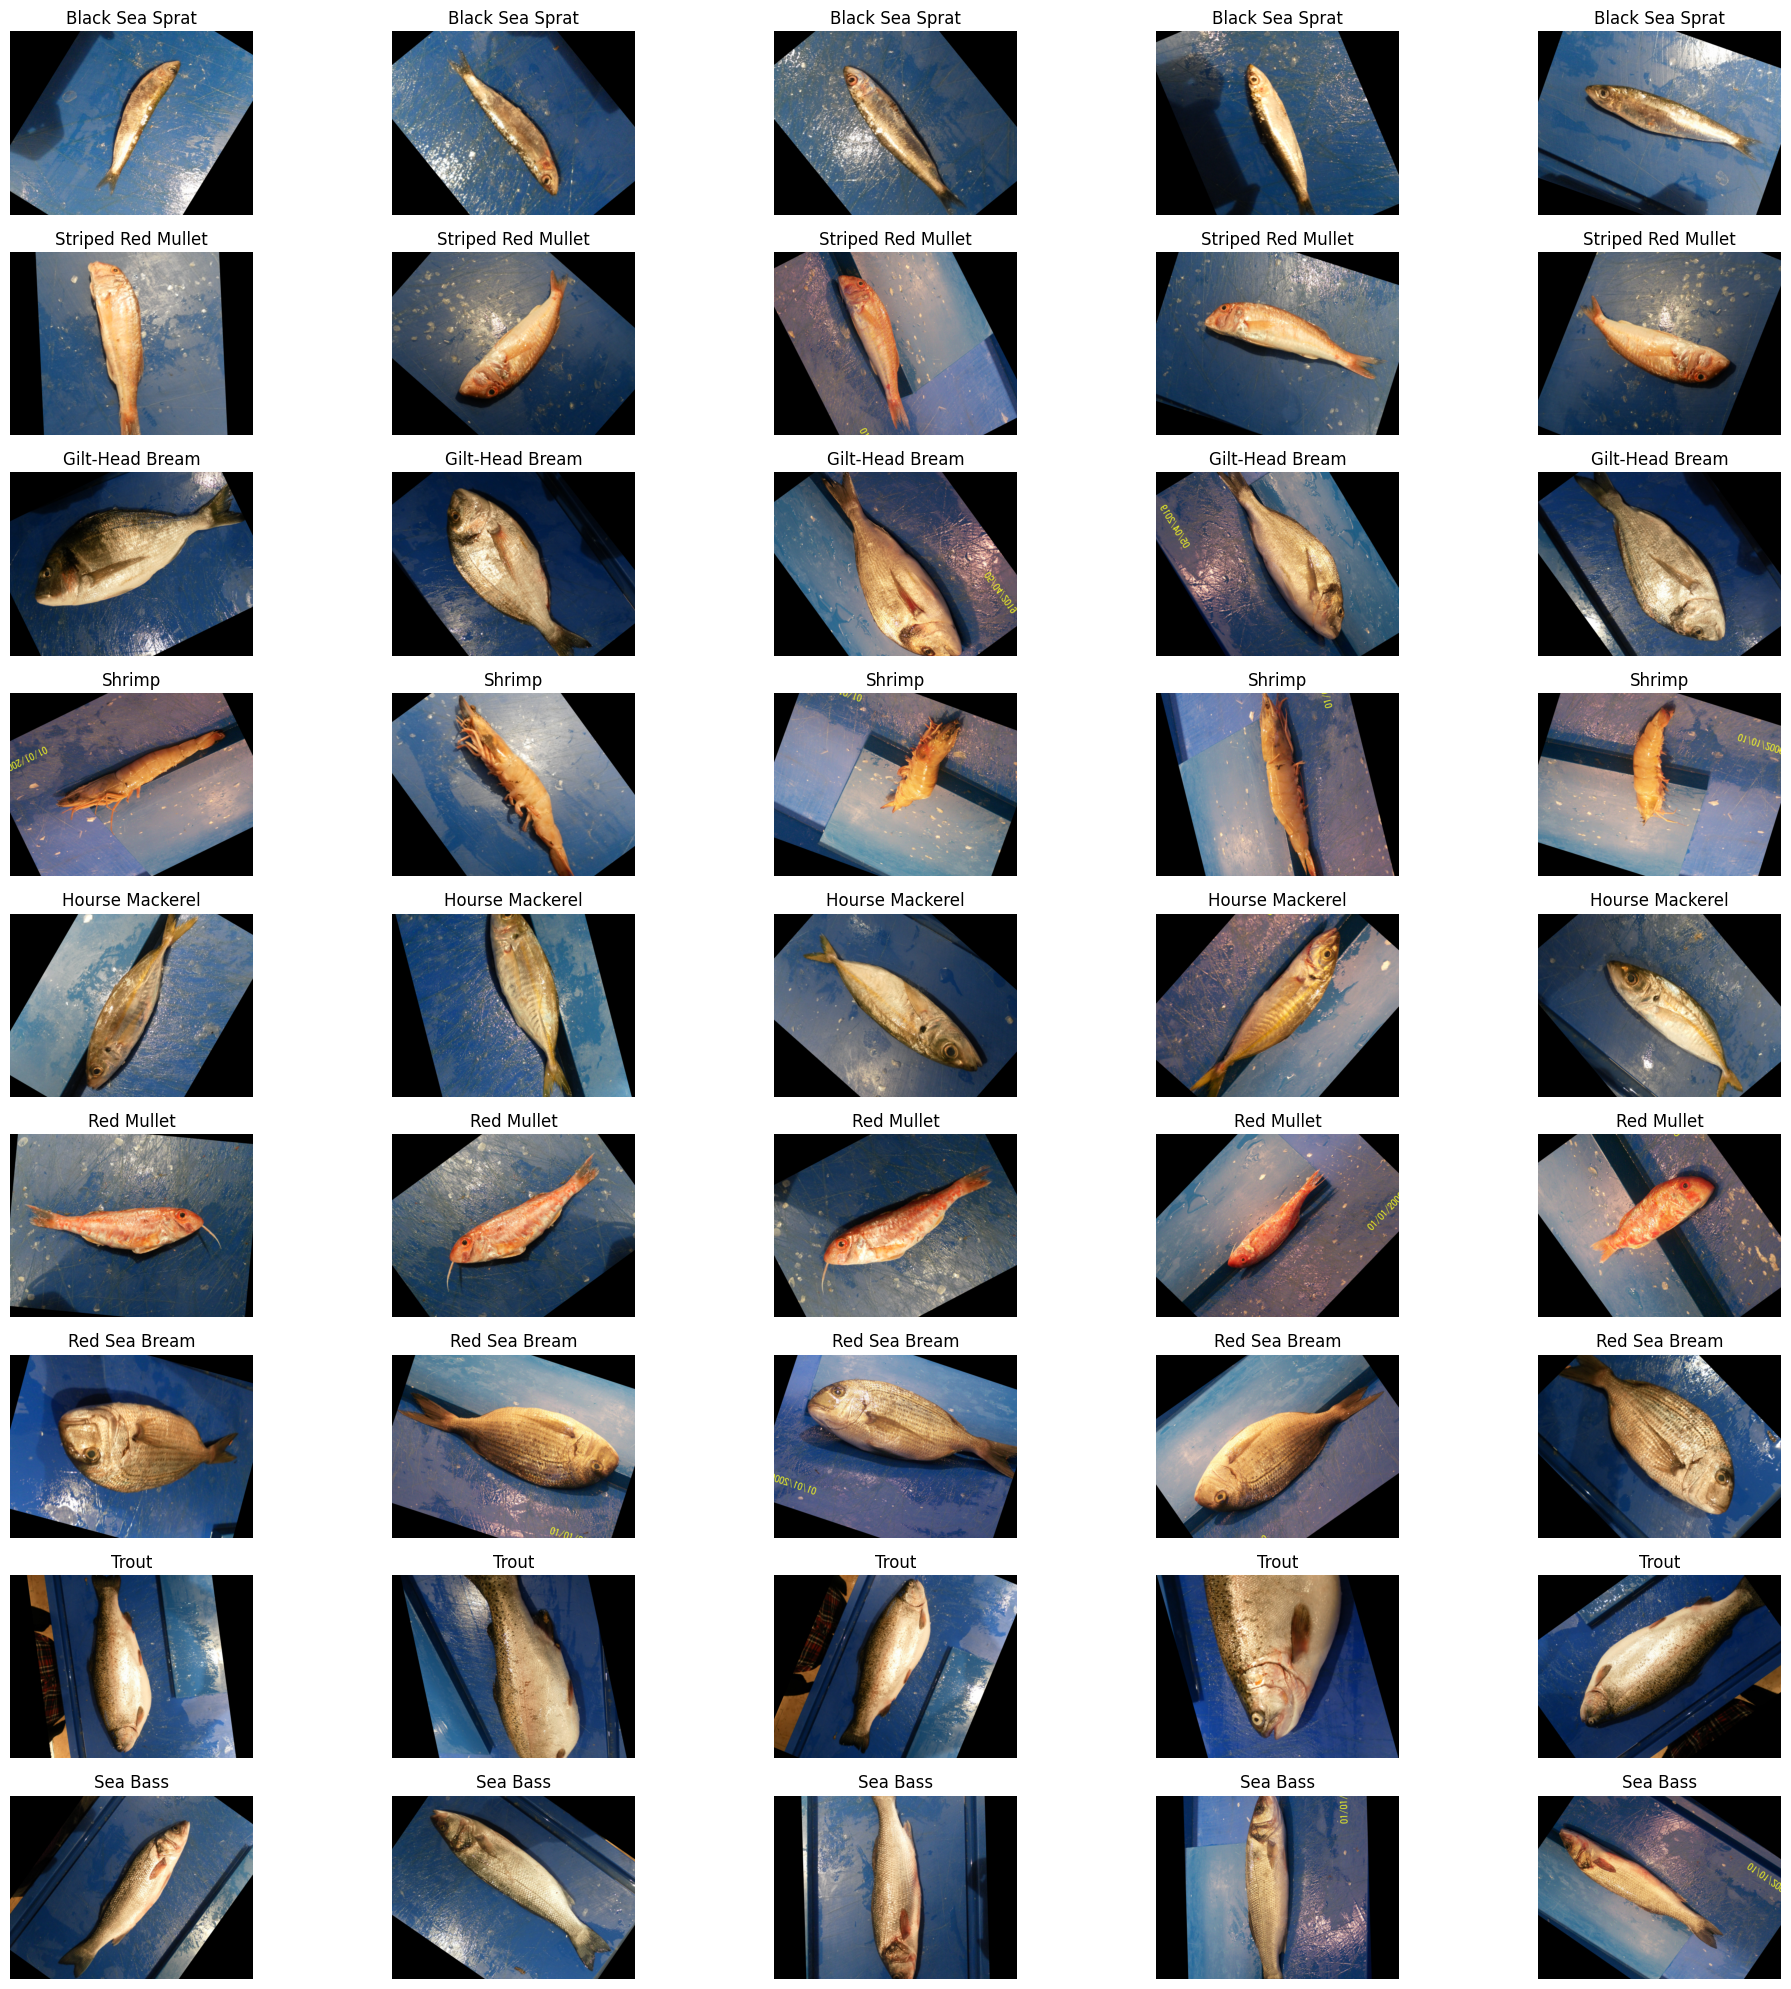

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_species_images(dataframe, classes, num_images_per_class=5):
    plt.figure(figsize=(20, 20))

    for idx, species in enumerate(classes):
        species_images = dataframe[dataframe['label'] == species]['filepath'].values
        selected_images = random.sample(list(species_images), min(num_images_per_class, len(species_images)))

        for i, img_path in enumerate(selected_images):
            plt.subplot(len(classes), num_images_per_class, idx * num_images_per_class + i + 1)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(species)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot images
plot_species_images(data_df, classes)

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42, stratify=data_df['label'])

Data augmentation and preprocessing

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=keras.applications.densenet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.densenet.preprocess_input)

Create data generators:
Use flow_from_dataframe to create data generators for training and testing datasets

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7200 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


Load the DenseNet121 model with pre-trained weights

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
#Freeze the base model
base_model.trainable = False

In [ ]:
#Add custom layers on top of the base model:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 9225      
                                                                 
Total params: 8096329 (30.89 MB)
Trainable params: 1058825 (4.04 MB)
Non-trainable params: 7037504 (26.85 MB)
____________

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
225/225 [==============================] - 199s 821ms/step - loss: 0.3403 - accuracy: 0.8892 - val_loss: 0.0238 - val_accuracy: 0.9967
Epoch 2/10
225/225 [==============================] - 168s 748ms/step - loss: 0.0796 - accuracy: 0.9719 - val_loss: 0.0156 - val_accuracy: 0.9950
Epoch 3/10
225/225 [==============================] - 161s 715ms/step - loss: 0.0576 - accuracy: 0.9819 - val_loss: 0.0057 - val_accuracy: 0.9989
Epoch 4/10
225/225 [==============================] - 165s 731ms/step - loss: 0.0515 - accuracy: 0.9821 - val_loss: 0.0092 - val_accuracy: 0.9972
Epoch 5/10
225/225 [==============================] - 161s 715ms/step - loss: 0.0523 - accuracy: 0.9824 - val_loss: 0.0114 - val_accuracy: 0.9967
Epoch 6/10
225/225 [==============================] - 161s 716ms/step - loss: 0.0440 - accuracy: 0.9860 - val_loss: 0.0142 - val_accuracy: 0.9950
Epoch 7/10
225/225 [==============================] - 160s 710ms/step - loss: 0.0527 - accuracy: 0.9800 - val_loss: 0.0057 -

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:.2f}%')

57/57 [==============================] - 18s 321ms/step - loss: 0.0046 - accuracy: 0.9983
Test accuracy: 99.83%


In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=classes))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       200
Striped Red Mullet       1.00      0.99      1.00       200
   Gilt-Head Bream       1.00      0.99      1.00       200
            Shrimp       1.00      1.00      1.00       200
   Hourse Mackerel       1.00      1.00      1.00       200
        Red Mullet       0.99      1.00      1.00       200
     Red Sea Bream       1.00      1.00      1.00       200
             Trout       1.00      0.99      1.00       200
          Sea Bass       1.00      1.00      1.00       200

          accuracy                           1.00      1800
         macro avg       1.00      1.00      1.00      1800
      weighted avg       1.00      1.00      1.00      1800



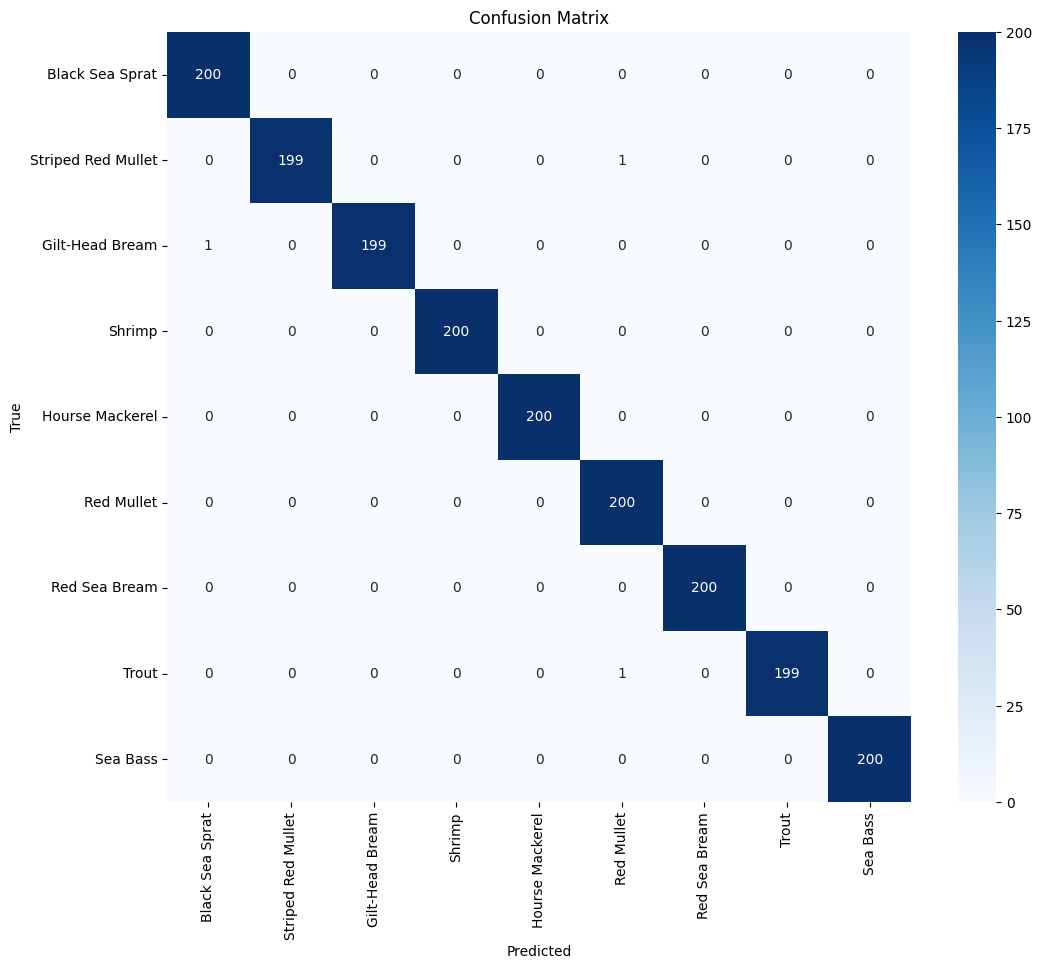

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Load the pretrained model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add a GlobalAveragePooling layer to the base model for feature extraction
feature_extractor_model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D()
])

# Extract features from the training and testing datasets
train_features = feature_extractor_model.predict(train_generator)
test_features = feature_extractor_model.predict(test_generator)

# Get the corresponding labels
train_labels = train_generator.classes
test_labels = test_generator.classes

57/57 [==============================] - 17s 292ms/step


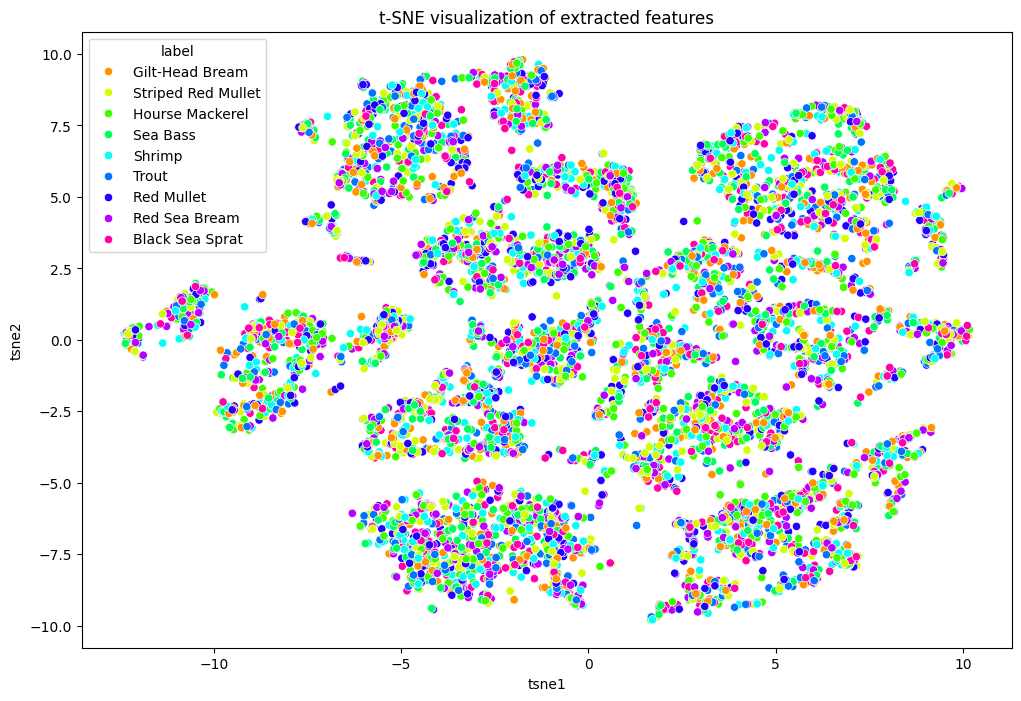

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
train_features_tsne = tsne.fit_transform(train_features)

# Create a DataFrame for visualization
train_features_df = pd.DataFrame(data=train_features_tsne, columns=['tsne1', 'tsne2'])
train_features_df['label'] = train_labels
train_features_df['label'] = train_features_df['label'].apply(lambda x: classes[x])

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(x='tsne1', y='tsne2', hue='label', palette=sns.color_palette("hsv", len(classes)), data=train_features_df, legend='full')
plt.title('t-SNE visualization of extracted features')
plt.show()

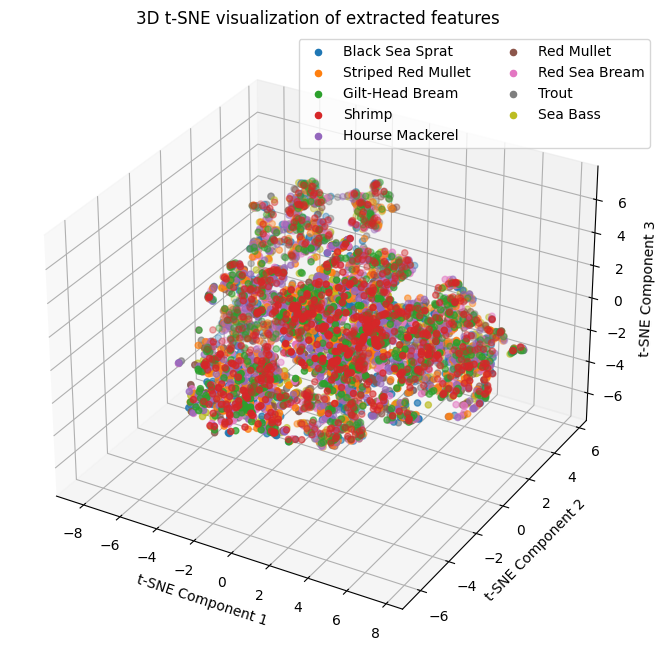

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce dimensionality with t-SNE to 3 components for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
train_features_tsne_3d = tsne.fit_transform(train_features)

# Create a DataFrame for visualization
train_features_df_3d = pd.DataFrame(data=train_features_tsne_3d, columns=['tsne1', 'tsne2', 'tsne3'])
train_features_df_3d['label'] = train_labels
train_features_df_3d['label'] = train_features_df_3d['label'].apply(lambda x: classes[x])

# Plot the t-SNE visualization in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
for label in classes:
    indices = train_features_df_3d['label'] == label
    ax.scatter(
        train_features_df_3d.loc[indices, 'tsne1'],
        train_features_df_3d.loc[indices, 'tsne2'],
        train_features_df_3d.loc[indices, 'tsne3'],
        label=label
    )

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D t-SNE visualization of extracted features')
ax.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=2)
plt.show()

In [ ]:
batch_size = 32
num_samples = len(test_generator.filenames)
num_batches = num_samples // batch_size + 1

y_true = []
y_pred_classes = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)

    batch_x, batch_y = test_generator[i]
    batch_pred = model.predict(batch_x)

    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred_classes.extend(np.argmax(batch_pred, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

1/1 [==============================] - 2s 2s/step


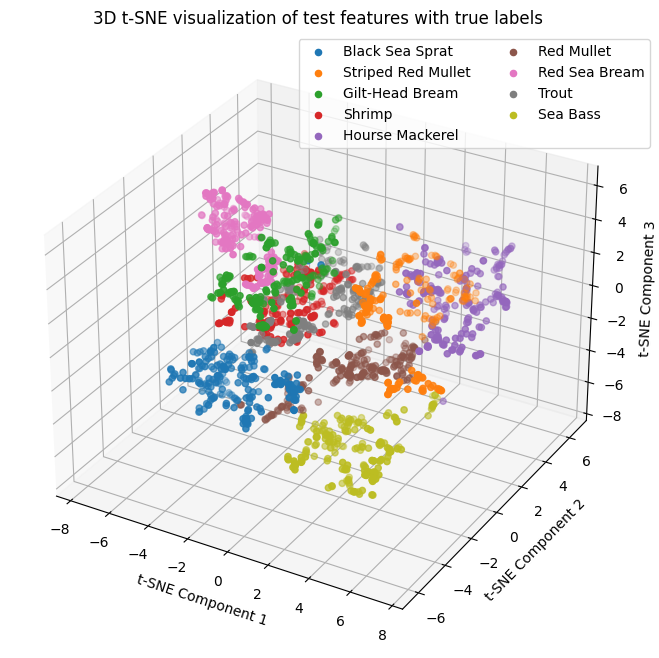

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
# Convert the predicted classes to class labels
y_pred_labels = np.array([classes[idx] for idx in y_pred_classes])

# Reduce dimensionality with t-SNE to 3 components for 3D visualization
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
test_features_tsne_3d = tsne.fit_transform(test_features)

# Create a DataFrame for visualization
test_features_df_3d = pd.DataFrame(data=test_features_tsne_3d, columns=['tsne1', 'tsne2', 'tsne3'])
test_features_df_3d['true_label'] = y_true
test_features_df_3d['true_label'] = test_features_df_3d['true_label'].apply(lambda x: classes[x])
test_features_df_3d['pred_label'] = y_pred_labels

# Plot the t-SNE visualization in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
for label in classes:
    indices = test_features_df_3d['true_label'] == label
    ax.scatter(
        test_features_df_3d.loc[indices, 'tsne1'],
        test_features_df_3d.loc[indices, 'tsne2'],
        test_features_df_3d.loc[indices, 'tsne3'],
        label=label
    )

ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')
ax.set_title('3D t-SNE visualization of test features with true labels')
ax.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=2)
plt.show()

In [ ]:
# Count the number of hidden nodes in each layer
hidden_nodes_per_layer = [layer.units for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]
total_hidden_nodes = sum(hidden_nodes_per_layer)
print("Total hidden nodes:", total_hidden_nodes)

Total hidden nodes: 1033
